## Yoga Pose Image Classifiers using Flux.jl

This exercise is intended to gain experience in convolutional neural networks for image recognition using the Flux library in Julia.  Below I will build a small zoo of various convolutional neural network architectures and at the end compare their performance at the task of recognizing yoga poses in images.   

In [3]:
using Images
using Flux: onehotbatch, onecold
using Base.Iterators: partition
using Statistics
using Flux, Flux.Optimise
using Flux: crossentropy, Momentum, ADAM
using DataFrames
using Augmentor
using MLDataPattern
using BSON
using CUDA

┌ Info: Precompiling Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
└ @ Base loading.jl:1278
┌ Info: Precompiling Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1278


┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1278
┌ Info: Precompiling Augmentor [02898b10-1f73-11ea-317c-6393d7073e15]
└ @ Base loading.jl:1278
┌ Info: Precompiling BSON [fbb218c0-5317-5bc6-957e-2ee96dd4b1f0]
└ @ Base loading.jl:1278


In [4]:
ENV["COLUMNS"] = 1000
ENV["ROWS"] = 1000

1000

### Data Loading & Augmentation

I did a cursory search online for others who might have built similar projects and found Anastasia Marchenkova's [blog post](https://www.amarchenkova.com/2018/03/25/convolutional-neural-network-yoga-poses/).  She constructed a dataset of approximately 700 images pulled from searching Google and Flickr for 10 yoga poses. I started out using her dataset, but soon wanted to add more poses and ended up building a new dataset from scratch. Given we both scraped Google Images several of the same images appear in my dataset.

The images in this dataset were collected by scraping Google Images (See the Web Scraper Notebook in this project folder).  I attempted to collect images of a single person performing the specified pose from a variety of positions and include a diversity of gender, age, body-type, race, and settings. While there is some diversity in the data it is likely not equal among all poses, and in all cases there is bias toward fit body-types and females. In some photos there are multiple people and some images showing computer-rendered humans are in the dataset. For each pose there is also different orientations represented (straight on, from side, etc), however the bias is towards one or a few common angles. The raw images come in a a variety of sizes and resolutions. I manually cleaned up the data to balance out the number of images per pose, remove low quality images, and separate into training and test sets. Some images appeared multiple times, and in some cases I deleted them and in others I introduced agumentations such as horizontal flips, cropping, and adding color filters. Overall the dataset is not great quality, but should suffice for this exercise.

I am new to both Julia and Deep Learning Frameworks, and really programming in general, so I had a lot of catching up to do in the course of this project.  The first stumbling block was loading the data into a structure that I could feed to a neural network.  Keras/TensorFlow and PyTorch have more developed ecosystems and include easy to use functions for getting image data from folders into a structure ready for feeding to a neural network.  Flux is still lacking a standard package for this specific task. Luckily it was fairly easy to learn how to roll my own using base Julia. My dataset is small enough to fit into memory so I did not worry about implementing lazy loading or multithreading.

In [38]:
TRAIN_DIR = "Images/training_set"
TEST_DIR = "Images/test_set"
CLASSES = 24
IMG_SIZE = (96, 96)
COL_CHANNELS = 3
CLASS_LABELS = readdir(TRAIN_DIR)
BATCH_SIZE = 16

16

In [39]:
""" This function converts an image into a valid array structure for feeding to a Flux neural network. """

getarray(X) = Float32.(permutedims(channelview(X), (2, 3, 1)))

getarray (generic function with 1 method)

In [40]:
function FindBadImages(dir, color_chans)

""" The training data might include some images not matching proper color channels, this loop will find them. """

    badims_arr =[] 
    
    for (root, dirs, files) in walkdir(dir)
        
        for file in files
            try
                img = getarray(load(joinpath(root, file)))
            catch
                push!(badims_arr, string(basename(root),"-",file))
                continue
            end
            img = getarray(load(joinpath(root, file)))    
            if size(img)[3] != color_chans
                push!(badims_arr, string(basename(root),"-",file))
            end 
        end
    end
    
    return badims_arr
end

FindBadImages (generic function with 1 method)

In [10]:
FindBadImages(TRAIN_DIR, 3)

┌ Info: Precompiling ImageMagick [6218d12a-5da1-5696-b52f-db25d2ecc6d1]
└ @ Base loading.jl:1278
┌ Info: Precompiling ImageIO [82e4d734-157c-48bb-816b-45c225c6df19]
└ @ Base loading.jl:1278
┌ Info: Precompiling PNGFiles [f57f5aa1-a3ce-4bc8-8ab9-96f992907883]
└ @ Base loading.jl:1278


Any[]

In [11]:
FindBadImages(TEST_DIR, 3)

Any[]

In [41]:
function LoadImagesFromDir(dir, img_size)
    
    """ Loads images and class labels from directory where folders are class names. 
        Outputs arrays with images and class names to be used for random tests. """
    
    img_arr = []
    class_arr =[] 
    
    for (root, dirs, files) in walkdir(dir)
        
        for file in files
            img = load(joinpath(root, file))
            img_rs = imresize(img, img_size)
            push!(img_arr, img_rs)
            push!(class_arr, basename(root))
        end
    end
    
    return img_arr, class_arr
end

LoadImagesFromDir (generic function with 1 method)

In [42]:
test_imgs, test_class = LoadImagesFromDir(TEST_DIR, IMG_SIZE);

In [43]:
function ImageDataGenFromDir(dir, img_size; batch_size=1, val_pct=0, augims=false, aug_pl=NoOp)
    
    """ Loads image data from directory where folders are class names. 
        Applys augmentation and splits into train and validation sets, optionally.
        Outputs dataset ready to be fed into Flux neural network."""
    
    img_arr = []
    class_arr =[] 
    
    for (root, dirs, files) in walkdir(dir)
        
        for file in files
            img = load(joinpath(root, file))
            img_rs = imresize(img, img_size)
            push!(img_arr, img_rs)
            push!(class_arr, basename(root))
            if augims 
                img_aug = imresize(augment(img_rs, aug_pl), img_size)
                push!(img_arr, img_aug)
                push!(class_arr, basename(root))
            end
        end
    end
    
    imgs = [getarray(img_arr[i]) for i in 1:length(img_arr)]
    classes=unique(class_arr)
    labels = onehotbatch([i for i in class_arr], classes)
    imgs, labels = shuffleobs((imgs, labels))
    
    if val_pct > 0
        (trainX, trainY), (valX, valY) = splitobs((imgs, labels), at = 1-val_pct)
        trainset = ([(cat(trainX[i]..., dims = 4), trainY[:,i]) for i in partition(1:length(trainX), batch_size)]) |> gpu
        valX = cat(valX[1:end]..., dims = 4) |> gpu
        return trainset, valX, valY
    end
    
    dataset = ([(cat(imgs[i]..., dims = 4), labels[:,i]) for i in partition(1:length(imgs), batch_size)]) |> gpu
    return dataset
end

ImageDataGenFromDir (generic function with 1 method)

In [44]:
testset = ImageDataGenFromDir(TEST_DIR, IMG_SIZE, batch_size=BATCH_SIZE);

In [45]:
#Image augmentation operations:
aug_ops = ShearX(-3:3) |> 
        Zoom([0.9, 1, 1.1]) |> 
        FlipX() * NoOp()

trainset, valX, valY = ImageDataGenFromDir(TRAIN_DIR, IMG_SIZE, batch_size=BATCH_SIZE, val_pct=0.1, augims=true, aug_pl=aug_ops);

### Accuracy & Loss Functions

In [46]:
loss(m, x, y) = sum(crossentropy(m(x), y))
accuracy(m, x, y) = mean(onecold(m(x), 1:24) .== onecold(y, 1:24))    

accuracy (generic function with 1 method)

In [47]:
function accuracy_by_class(m, x, class_labels)
    """ Accuracy by class """
    class_guess = zeros(24)
    class_correct = zeros(24)
    class_total = zeros(24)
    for i in 1:size(x)[1]
        tpreds = m(x[i][1])
        tlab = x[i][2]
        for j = 1:size(tpreds)[2]
                pred_class = findmax(tpreds[:, j])[2]
                actual_class = findmax(tlab[:, j])[2]
                class_guess[pred_class] += 1
                if pred_class == actual_class
                    class_correct[pred_class] += 1
                end
                class_total[actual_class] += 1
        end
    end
    
    class_acc = class_correct ./ class_total
    return DataFrame([(class=class_labels[i], accuracy=class_acc[i]*100, correct_count=class_correct[i], guess_count=class_guess[i], act_count=class_total[i]) for i in 1:24])
end

accuracy_by_class (generic function with 1 method)

In [48]:
function random_test(m, imgs, classes, size, labels)
    """ Test model on a random sample from the given test images. """
    
    ids = rand(1:length(imgs), size)
    rand_test = getarray.(imgs[ids])
    rand_test = cat(rand_test..., dims = 4)
    rand_truth = classes[ids]
    preds_test = m(rand_test)
    col_headers = ["Pose"]
    for i in 1:size
        push!(col_headers, string("test","_",i))
    end
    return DataFrame([labels round.(preds_test.*100, digits=2)], col_headers), ids
end

random_test (generic function with 1 method)

### YogAlexNet

[AlexNet](http://vision.stanford.edu/teaching/cs231b_spring1415/slides/alexnet_tugce_kyunghee.pdf) was one of the early breakthroughs in Convolutional Neural Network (CNN) image classifiers, winning the ImageNet challenge in 2012.  It's authors concluded that the depth of the network was very important for the model's performance, and that GPU's were making it tractable to compute those deep networks. My implementation here includes 5 convolutional layers with filter sizes 11x11, 5x5 and 3x3 leading into 3 fully connected layers outputting pose predictions.

In [53]:

YogAlexNetMini = Chain(                                             # Weighted Layers:
    Conv((11,11), 3=>24, relu, stride=4, pad=SamePad()),            # Conv1
    MaxPool((3,3), stride=2),
    
    Conv((5,5), 24=>64, relu, stride=1, pad=SamePad()),            # Conv2
    MaxPool((3,3), stride=2),
    
    Conv((3,3), 64=>96, relu, stride=1, pad=SamePad()),           # Conv3
    Conv((3,3), 96=>96, relu, stride=1, pad=SamePad()),           # Conv4
    Conv((3,3), 96=>64, relu, stride=1, pad=SamePad()),           # Conv5
    MaxPool((3,3), stride=2),
    
    x -> reshape(x, :, size(x, 4)),
    Dense(256, 496),                                              # FC1
    Dense(496, 496),                                              # FC2
    Dense(496, 24),                                                # FC3
    softmax
) |> gpu

yan_opt = Momentum()

Momentum(0.01, 0.9, IdDict{Any,Any}())

### Training the YogAlexNet

In [54]:
epochs = 30

for epoch = 1:epochs
    for d in trainset
       
        gs = gradient(params(YogAlexNetMini)) do
            l = loss(YogAlexNetMini, d...)
        end
        update!(yan_opt, params(YogAlexNetMini), gs)
    end
    @show accuracy(YogAlexNetMini, valX, valY), epoch
end

LoadError: [91mGPU compilation of kernel broadcast_kernel(CUDA.CuKernelContext, CuDeviceArray{Bool,1,1}, Base.Broadcast.Broadcasted{Nothing,Tuple{Base.OneTo{Int64}},typeof(==),Tuple{Base.Broadcast.Extruded{CuDeviceArray{Int64,1,1},Tuple{Bool},Tuple{Int64}},Base.Broadcast.Extruded{Array{Int64,1},Tuple{Bool},Tuple{Int64}}}}, Int64) failed[39m
[91mKernelError: passing and using non-bitstype argument[39m

[91mArgument 4 to your kernel function is of type Base.Broadcast.Broadcasted{Nothing,Tuple{Base.OneTo{Int64}},typeof(==),Tuple{Base.Broadcast.Extruded{CuDeviceArray{Int64,1,1},Tuple{Bool},Tuple{Int64}},Base.Broadcast.Extruded{Array{Int64,1},Tuple{Bool},Tuple{Int64}}}}, which is not isbits:[39m
[91m  .args is of type Tuple{Base.Broadcast.Extruded{CuDeviceArray{Int64,1,1},Tuple{Bool},Tuple{Int64}},Base.Broadcast.Extruded{Array{Int64,1},Tuple{Bool},Tuple{Int64}}} which is not isbits.[39m
[91m    .2 is of type Base.Broadcast.Extruded{Array{Int64,1},Tuple{Bool},Tuple{Int64}} which is not isbits.[39m
[91m      .x is of type Array{Int64,1} which is not isbits.[39m



In [41]:
using BSON: @save

@save "YogAlexNetMini.bson" YogAlexNetMini

In [15]:
using BSON: @load

@load "YogAlexNetMini.bson" YogAlexNetMini

### Testing the YogAlexNet

In [42]:
scores, rand_ids = random_test(YogAlexNetMini, test_imgs, test_class, 15, CLASS_LABELS);

In [43]:
scores

,Pose,test_1,test_2,test_3,test_4,test_5,test_6,test_7,test_8,test_9,test_10,test_11,test_12,test_13,test_14,test_15
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,bridge,0.0,0.0,0.0,0.0,0.03,21.31,0.0,0.0,0.0,0.0,0.0,0.0,0.03,0.0,0.0
2,cat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,chair,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.64,0.07,0.0,0.0,0.0,0.0,0.0,79.18
4,childs,0.0,0.0,0.0,0.0,99.87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,cobraupdog,0.0,0.0,0.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,cow,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,cranecrow,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,downwarddog,100.0,0.0,0.0,0.0,0.0,78.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.14
9,halfmoon,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,,,,,,,,,,,,,,

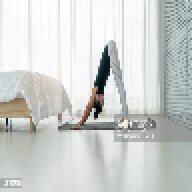
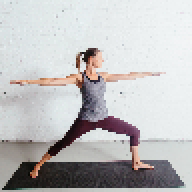
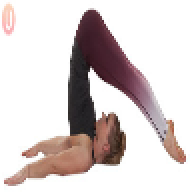
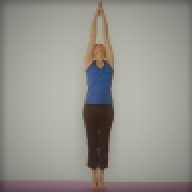
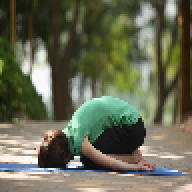
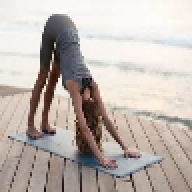
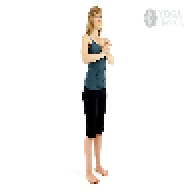
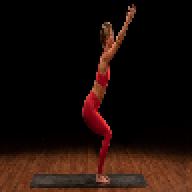
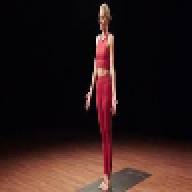
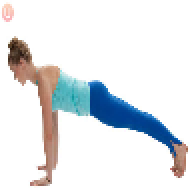
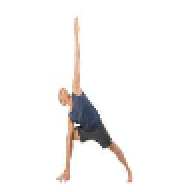
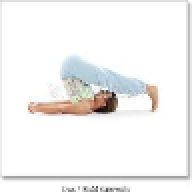
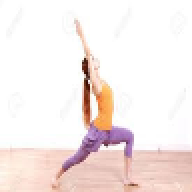
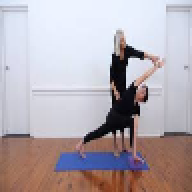
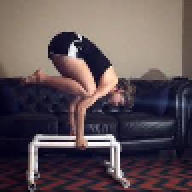

In [44]:
[test_imgs[i] for i in rand_ids]

In [35]:
accuracy(YogAlexNetMini, testset[1]...)*100

83.59375

In [36]:
accuracy_by_class(YogAlexNetMini, testset, CLASS_LABELS)

,class,accuracy,correct_count,guess_count,act_count
,String,Float64,Float64,Float64,Float64
1,bridge,90.0,45.0,55.0,50.0
2,cat,88.0,44.0,52.0,50.0
3,chair,82.0,41.0,47.0,50.0
4,childs,82.0,41.0,47.0,50.0
5,cobraupdog,88.0,44.0,56.0,50.0
6,cow,92.0,46.0,62.0,50.0
7,cranecrow,74.0,37.0,39.0,50.0
8,downwarddog,90.0,45.0,51.0,50.0
9,halfmoon,94.0,47.0,56.0,50.0


94% accuracy is better than I was expecting! That is a good result for the first network.  It took about 24 hours to train for 90 epochs on a signle CPU thread. I will need to find another way to train the next networks because I could be waiting a long time. 

### Yoga VGG16 Architecture

AlexNet proved deeper networks are more powerful, so how much deeper can we go? A group of researchers from the Visual Geometry Group at the University of Oxford pushed the boundaries a bit further in their [paper](https://arxiv.org/abs/1409.1556) presenting a general architecture in varied levels of depth.  This architecture makes use of multiple layers of 3x3 filters to replace the larger 5x5 and 11x11 filters seen in AlexNet.  This produces a receptive field with similar size to the larger kernel filters but with far fewer trainable parameters, improving training time and enabling deeper networks.

The paper proposed many different configurations, and the one I chose to implement was labeled D in the paper, consisting of 16 weight layers and using 3x3 filters in every convolution layer.

In [39]:
Yoga_VGG13mini = Chain(
    Conv((3,3), 3=>32, relu, pad=(1, 1), stride=(1, 1)),
    BatchNorm(32),
    Conv((3,3), 32=>32, relu, pad=(1, 1), stride=(1, 1)),
    BatchNorm(32),
    MaxPool((2,2)),
    
    Conv((3,3), 32=>64, relu, pad=(1, 1), stride=(1, 1)),
    BatchNorm(64),
    Conv((3,3), 64=>64, relu, pad=(1, 1), stride=(1, 1)),
    BatchNorm(64),
    MaxPool((2,2)),
    
    Conv((3,3), 64=>128, relu, pad=(1, 1), stride=(1, 1)),
    BatchNorm(128),
    Conv((3,3), 128=>128, relu, pad=(1, 1), stride=(1, 1)),
    BatchNorm(128),
    MaxPool((2,2)),
    
    Conv((3,3), 128=>256, relu, pad=(1, 1), stride=(1, 1)),
    BatchNorm(256),
    Conv((3,3), 256=>256, relu, pad=(1, 1), stride=(1, 1)),
    BatchNorm(256),
    Conv((3,3), 256=>256, relu, pad=(1, 1), stride=(1, 1)),
    BatchNorm(256),
    MaxPool((2,2)),
    
    x -> reshape(x, :, size(x, 4)),
    Dense(9216, 496),
    Dropout(0.5),
    Dense(496, 496),
    Dropout(0.5),
    Dense(496, 24),
    softmax)

vgg_opt = Momentum(0.001)

Momentum(0.001, 0.9, IdDict{Any,Any}())

### Training the Yoga VGG16

In [ ]:
epochs = 5

for epoch = 1:epochs
    for d in trainset
       
        gs = gradient(params(Yoga_VGG13mini)) do
            l = loss(Yoga_VGG13mini, d...)
        end
        update!(vgg_opt, params(Yoga_VGG13mini), gs)
    end
    @show accuracy(Yoga_VGG13mini, valX, valY), epoch
end

In [34]:
using BSON: @save

@save "Yoga_VGG16.bson" Yoga_VGG13mini

### Testing the Yoga VGG16

,,,,,,,,,

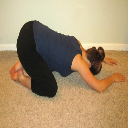
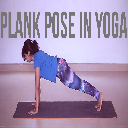
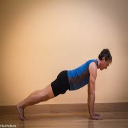
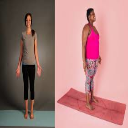
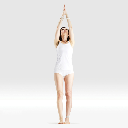
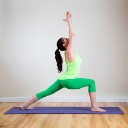
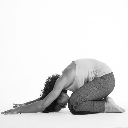
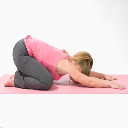
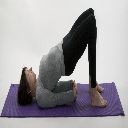
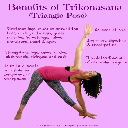

In [59]:
scores, rand_ids = random_test(Yoga_VGG13mini, test_imgs, test_class, 15, CLASS_LABELS)

In [ ]:
[test_imgs[i] for i in rand_ids]

In [113]:
accuracy(Yoga_VGG13mini, testset[1]...)*100

68.0

In [115]:
accuracy_by_class(Yoga_VGG13mini, testset, CLASS_LABELS)

,class,accuracy,correct_count,guess_count,act_count
,String,Float64,Float64,Float64,Float64
1,bridge,53.3333,8.0,13.0,15.0
2,childs,66.6667,10.0,16.0,15.0
3,downwarddog,93.3333,14.0,15.0,15.0
4,mountain,40.0,6.0,6.0,15.0
5,plank,86.6667,13.0,16.0,15.0
6,seatedforwardbend,73.3333,11.0,15.0,15.0
7,tree,93.3333,14.0,23.0,15.0
8,trianglepose,60.0,9.0,10.0,15.0
9,warrior1,73.3333,11.0,21.0,15.0


### Yoga ResNet Architecture

Next on the list is ResNet.  ResNet introduced a new technique to address an issue seen in experiments where adding more layers to a model resulted in less accuracy.  As networks went deeper they had to deal with vanishing gradients, that is during back propagation the value of the partial derivatives can become insignificant when propagaded through many layers.

ResNet's innovation came in the form of implementing Identity Shortcut and Projection Shortcut connections. Beyond that the other building blocks resemble VGG architecture.

I referenced Julia Discourse user OTapio's [post](https://discourse.julialang.org/t/a-implementation-of-resnet-18-uses-lot-of-gpu-memory/36389) to get a grasp on how to implement the ResNet in Flux.  To make things more interesting and test my understanding I extended the number of layers from 18 to 34.

![resnet_block](reference_material/resnet_block.png)

![resnet_block2](reference_material/resnet-blockw1x1conv.svg)

In [13]:
""" Identity Layer takes input through 2 3x3 conv layers, maintaining n number of filters"""
identity_layer(n) = Chain(
    Conv((3,3), n=>n, pad=(1,1), stride=(1,1)),
    BatchNorm(n, relu),
    Conv((3,3), n=>n, pad=(1,1), stride=(1,1)),
    BatchNorm(n, relu)
    )

""" Identity Layer takes input through 2 3x3 conv layers, outputting 2*n number of filters"""
convol_layer(n) = Chain(
    Conv((3,3), n=>2*n, pad=(1,1), stride=(2,2)),
    BatchNorm(2*n, relu),
    Conv((3,3), 2*n=>2*n, pad=(1,1), stride=(1,1)),
    BatchNorm(2*n, relu)
    )
""" This is used for downsampling when making shortcut connections between layers with equal
    feature map depth."""
simple_convol(n) = Chain(
    Conv((1,1), n=>n, pad=(1,1), stride=(2,2)),
    BatchNorm(n, relu)
    )
""" This is used for downsampling when making shortcut connections between layers with different
    feature map depth. """
m_filter(n) = Chain(
    Conv((3,3), n=>2*n, pad=(1,1), stride=(2,2)),
    BatchNorm(2*n, relu)
    )

""" Container for filter to adjust inputs with different dimensions. """
struct DifDimShortcut
    filter::Chain
end

""" Sets the number of channels for combination of two blocks. """
DifDimShortcut(n) = DifDimShortcut(m_filter(n))

""" Defining function for passing two inputs to DifDimShortcut to Flux.SkipConnection. """
function (sc::DifDimShortcut)(x,y)
    z = sc.filter(y)
    return x + z
end

DifDimShortcut

In [22]:
Yoga_ResNet18mini = Chain(
    
    Conv((7,7), 3=>32, pad=(3, 3), stride=(2, 2)),
    BatchNorm(32, relu),
    MaxPool((3,3), pad = (5,5), stride=(1,1)),
    
    SkipConnection(identity_layer(32), +),
    SkipConnection(identity_layer(32), +),
    
    SkipConnection(convol_layer(32), DifDimShortcut(32)),
    
    SkipConnection(identity_layer(64), +),
    
    SkipConnection(convol_layer(64), DifDimShortcut(64)),
    
    SkipConnection(identity_layer(128), +),
    MeanPool((7,7)),
    
    x -> reshape(x, :, size(x, 4)),
    Dense(512, 24),
    softmax
    )
    


yrn_opt = Momentum(0.01)

Momentum(0.01, 0.9, IdDict{Any,Any}())

In [28]:
using BSON: @load

@load "Yoga_ResNet_mini.bson" Yoga_ResNet18mini


yrn_opt = Momentum()


vgg_accuracy (generic function with 1 method)

### Training the Yoga ResNet

In [25]:
epochs = 10

for epoch = 1:epochs
    for d in trainset
       
        gs = gradient(params(Yoga_ResNet18mini)) do
            l = loss(Yoga_ResNet18mini, d...)
        end
        update!(yrn_opt, params(Yoga_ResNet18mini), gs)
    end
    @show accuracy(Yoga_ResNet18mini, valX, valY), epoch
end

(accuracy(Yoga_ResNet18mini, valX, valY), epoch) = (0.6366120218579235, 1)
(accuracy(Yoga_ResNet18mini, valX, valY), epoch) = (0.5182149362477231, 2)
(accuracy(Yoga_ResNet18mini, valX, valY), epoch) = (0.5965391621129326, 3)
(accuracy(Yoga_ResNet18mini, valX, valY), epoch) = (0.6930783242258652, 4)
(accuracy(Yoga_ResNet18mini, valX, valY), epoch) = (0.7477231329690346, 5)
(accuracy(Yoga_ResNet18mini, valX, valY), epoch) = (0.8652094717668488, 6)
(accuracy(Yoga_ResNet18mini, valX, valY), epoch) = (0.8515482695810564, 7)
(accuracy(Yoga_ResNet18mini, valX, valY), epoch) = (0.9080145719489982, 8)
(accuracy(Yoga_ResNet18mini, valX, valY), epoch) = (0.9435336976320583, 9)
(accuracy(Yoga_ResNet18mini, valX, valY), epoch) = (0.9462659380692168, 10)


In [26]:
using BSON: @save

@save "Yoga_ResNet_mini.bson" Yoga_ResNet18mini


### Testing the Yoga ResNet18

In [27]:
scores, rand_ids = random_test(Yoga_ResNet18mini, test_imgs, test_class, 15, CLASS_LABELS);

In [28]:
scores

,Pose,test_1,test_2,test_3,test_4,test_5,test_6,test_7,test_8,test_9,test_10,test_11,test_12,test_13,test_14,test_15
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,bridge,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,93.21,0.0,0.0,0.0,0.0,0.0
2,cat,0.0,0.0,0.0,0.02,0.0,0.0,99.62,0.46,0.0,3.87,0.0,0.0,0.11,0.0,0.0
3,chair,99.77,0.0,0.0,0.0,97.58,0.38,0.0,2.03,0.01,0.0,0.0,0.0,0.0,89.14,0.09
4,childs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.54,0.0,0.0,0.0,0.0,0.0
5,cobraupdog,0.0,0.0,0.11,3.55,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.01,0.0,0.0,0.22
6,cow,0.0,0.0,0.0,95.63,0.0,0.0,0.28,0.02,0.0,0.03,0.0,99.99,0.0,0.0,0.01
7,cranecrow,0.0,0.0,0.0,0.02,0.02,0.0,0.0,0.04,0.0,0.01,0.0,0.0,0.0,0.73,0.02
8,downwarddog,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.13,0.0,0.0,0.05,0.11,3.88
9,halfmoon,0.0,0.0,0.0,0.02,0.04,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.23,0.0


,,,,,,,,,,,,,,

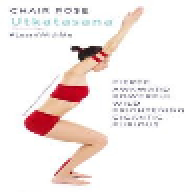
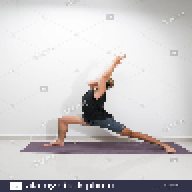
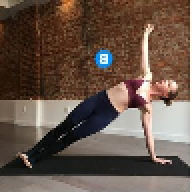
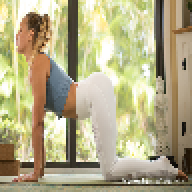
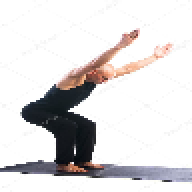
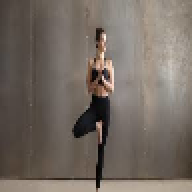
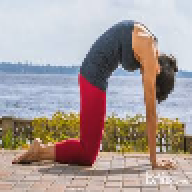
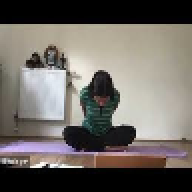
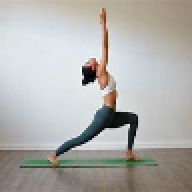
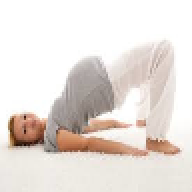
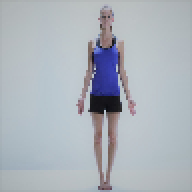
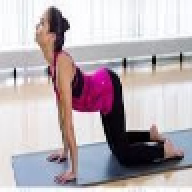
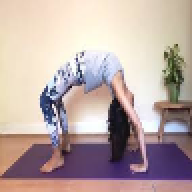
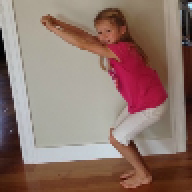
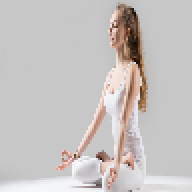

In [29]:
[test_imgs[i] for i in rand_ids]

In [30]:
accuracy(Yoga_ResNet18mini, testset[1]...)*100

92.1875

In [32]:
accuracy_by_class(Yoga_ResNet18mini, testset, CLASS_LABELS)

,class,accuracy,correct_count,guess_count,act_count
,String,Float64,Float64,Float64,Float64
1,bridge,94.0,47.0,54.0,50.0
2,cat,88.0,44.0,44.0,50.0
3,chair,94.0,47.0,49.0,50.0
4,childs,90.0,45.0,49.0,50.0
5,cobraupdog,84.0,42.0,45.0,50.0
6,cow,92.0,46.0,48.0,50.0
7,cranecrow,92.0,46.0,56.0,50.0
8,downwarddog,92.0,46.0,49.0,50.0
9,halfmoon,98.0,49.0,54.0,50.0


### Yoga Inception Architecture

To conclude this tour through famous CNN architectures I will implement a GoogLeNet style Inception network.  Incpetion blocks are a group of different network layers that try several different filter sizes on the same input then concatenates all the outputs from the individual layers into a tensor that gets passed to the next layer.

I built upon the approach taken in the ResNet network above where function constructors are used to build differnt layer chains. I needed additional help from the Julia Discourse, found [here](https://discourse.julialang.org/t/flux-params-does-not-recognize-parameters-with-x-layer-x-syntax/46832/4), to get the concatenation operation I use below. Additionally I referenced this [tutorial](https://www.youtube.com/watch?v=uQc4Fs7yx5I) on how to implement the inception block in PyTorch and adapted what I felt made sense to Julia here.

![inception_block](reference_material/inception_block.png)
![inception_block](reference_material/inception_blockv1.png)

In [33]:
struct InceptionBlock
    path1::Chain
    path2::Chain
    path3::Chain
    path4::Chain
end

Flux.@functor InceptionBlock

function InceptionBlock(chn_in, out_1, red_3, out_3, red_5, out_5, pool_out) 
    path1 = Chain(
                    Conv((1,1), chn_in=>out_1),
                    BatchNorm(out_1, relu)
                )
    
    path2 = Chain(
                    Conv((1,1), chn_in=>red_3),
                    BatchNorm(red_3, relu),
                    Conv((3,3), red_3=>out_3, pad=(1,1)),
                    BatchNorm(out_3, relu)
                )
    
    path3 = Chain(
                    Conv((1,1), chn_in=>red_5),
                    BatchNorm(red_5, relu),
                    Conv((5,5), red_5=>out_5, pad=(2,2)),
                    BatchNorm(out_5, relu)
                )
    
    path4 = Chain(
                    MaxPool((3,3), stride=(1,1), pad=(1,1)),
                    Conv((1,1), chn_in=>pool_out, pad=(1,1)),
                    BatchNorm(pool_out, relu)
                )
    
    InceptionBlock(path1, path2, path3, path4)
end

function (m::InceptionBlock)(x)
    cat(m.path1(x), m.path2(x), m.path3(x), m.path4(x), dims = 3)
end

In [53]:
YogLeNetv1 = Chain(
    #Input size = 3x224x224
    
    # Stage 1:
    Conv((7,7), 3=>64, pad=(3, 3), stride=(2, 2)),
    BatchNorm(64, relu),
    MaxPool((3,3), pad = (1,1), stride=(2,2)),
    
    # Stage 2:
    Conv((1,1), 64=>64, relu),
    Conv((3,3), 64=>192, relu),
    MaxPool((3,3), pad=(1,1), stride=(2,2)),
    
    #Output size = 192x28x28
    
    # Stage 3:
    InceptionBlock(192, 64, 96, 128, 16, 32, 32),
    InceptionBlock(256, 128, 128, 192, 32, 96, 64),
    MaxPool((3,3)),
    
    #Output size = 480x14x14
    
    # Stage 4:
    InceptionBlock(480, 192, 96, 208, 16, 48, 64),
    InceptionBlock(512, 160, 112, 224, 24, 64, 64),
    InceptionBlock(512, 128, 128, 256, 24, 64, 64),
    InceptionBlock(512, 112, 144, 288, 32, 64, 64),
    InceptionBlock(528, 256, 160, 320, 32, 128, 128),
    MaxPool((3,3), pad=(2,2), stride=(2,2)),
    
    #output size = 832x7x7
    
    # Stage 5:
    InceptionBlock(832, 256, 160, 320, 32, 128, 128),
    InceptionBlock(832, 384, 192, 384, 48, 128, 128),
    GlobalMeanPool(),
    x -> reshape(x, :, size(x, 4)),
    
    #Output size = 1024x1x1
    Dropout(0.4),
    Dense(1024,24),
    softmax
    )
    

ygn_v1_opt = Momentum()


Momentum(0.01, 0.9, IdDict{Any,Any}())

In [52]:
[size.(d) for d in trainset]

78-element Array{Tuple{NTuple{4,Int64},Tuple{Int64,Int64}},1}:
 ((224, 224, 3, 128), (24, 128))
 ((224, 224, 3, 128), (24, 128))
 ((224, 224, 3, 128), (24, 128))
 ((224, 224, 3, 128), (24, 128))
 ((224, 224, 3, 128), (24, 128))
 ((224, 224, 3, 128), (24, 128))
 ((224, 224, 3, 128), (24, 128))
 ((224, 224, 3, 128), (24, 128))
 ((224, 224, 3, 128), (24, 128))
 ((224, 224, 3, 128), (24, 128))
 ((224, 224, 3, 128), (24, 128))
 ((224, 224, 3, 128), (24, 128))
 ((224, 224, 3, 128), (24, 128))
 ⋮
 ((224, 224, 3, 128), (24, 128))
 ((224, 224, 3, 128), (24, 128))
 ((224, 224, 3, 128), (24, 128))
 ((224, 224, 3, 128), (24, 128))
 ((224, 224, 3, 128), (24, 128))
 ((224, 224, 3, 128), (24, 128))
 ((224, 224, 3, 128), (24, 128))
 ((224, 224, 3, 128), (24, 128))
 ((224, 224, 3, 128), (24, 128))
 ((224, 224, 3, 128), (24, 128))
 ((224, 224, 3, 128), (24, 128))
 ((224, 224, 3, 22), (24, 22))

### Training the YogLeNet

In [54]:
epochs = 20

for epoch = 1:epochs
    for d in trainset
       
        gs = gradient(params(YogLeNetv1)) do
            l = loss(YogLeNetv1, d...)
        end
        update!(ygn_v1_opt, params(YogLeNetv1), gs)
    end
    @show accuracy(YogLeNetv1, valX, valY), epoch
end

LoadError: DimensionMismatch("mismatch in dimension 1 (expected 26 got 28)")

In [23]:
using BSON: @save

@save "YogaLeNetv1.bson" YogLeNetv1

### Testing the YogLeNet

In [49]:
scores, rand_ids = random_test(YogLeNetv1, test_imgs, test_class, 15, CLASS_LABELS)

(10×16 DataFrame
│ Row │ Pose              │ test_1 │ test_2 │ test_3 │ test_4 │ test_5 │ test_6 │ test_7 │ test_8 │ test_9 │ test_10 │ test_11 │ test_12 │ test_13 │ test_14 │ test_15 │
│     │ Any               │ Any    │ Any    │ Any    │ Any    │ Any    │ Any    │ Any    │ Any    │ Any    │ Any     │ Any     │ Any     │ Any     │ Any     │ Any     │
├─────┼───────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 1   │ bridge            │ 0.01   │ 0.09   │ 0.16   │ 0.63   │ 0.88   │ 15.52  │ 10.41  │ 0.11   │ 0.0    │ 0.02    │ 0.06    │ 0.1     │ 0.0     │ 0.11    │ 14.19   │
│ 2   │ childs            │ 0.0    │ 99.07  │ 0.0    │ 2.95   │ 0.04   │ 0.0    │ 20.79  │ 0.01   │ 0.0    │ 0.0     │ 0.0     │ 0.0     │ 0.0     │ 0.01    │ 4.37    │
│ 3   │ downwarddog       │ 0.01   │ 0.02   │ 0.03   │ 35.91  │ 0.13   │ 0.49   │ 3.26   │ 0.02   │ 0.0    │ 0.0     │ 0.02    │ 0.03    │

,,,,,,,,,,,,,,

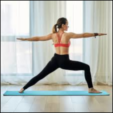
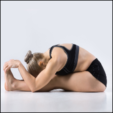
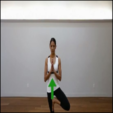
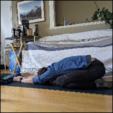
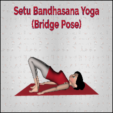
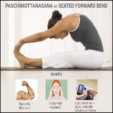
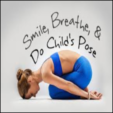
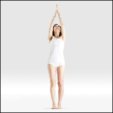
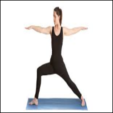
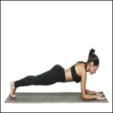
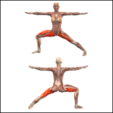
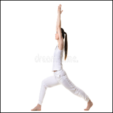
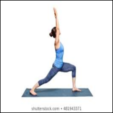
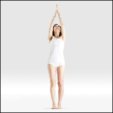
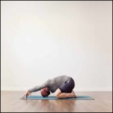

In [50]:
[test_imgs[i] for i in rand_ids]

In [51]:
accuracy(YogLeNetv1, testset[1]...)*100

62.5

In [52]:
accuracy_by_class(YogLeNetv1, testset, CLASS_LABELS)

,class,accuracy,correct_count,guess_count,act_count
,String,Float64,Float64,Float64,Float64
1,bridge,53.8462,7.0,9.0,13.0
2,childs,40.0,6.0,10.0,15.0
3,downwarddog,46.6667,7.0,10.0,15.0
4,mountain,53.3333,8.0,9.0,15.0
5,plank,73.3333,11.0,16.0,15.0
6,seatedforwardbend,46.6667,7.0,33.0,15.0
7,tree,66.6667,10.0,14.0,15.0
8,trianglepose,73.3333,11.0,14.0,15.0
9,warrior1,40.0,6.0,15.0,15.0


### Next Steps:

* Add narrative, notes, and comments
* Create helper functions for plotting training, plotting predictions
* Model Comparison summary
* Deploy best image classifer in a web app

## Old code Snipetts

In [8]:
train_imgs = []
train_class = []

#Image augmentation operations:
aug_pl = ShearX(-5:5) * ShearY(-5:5) |> 
        Zoom([0.85, 0.9, 1, 1.1, 1.2, 1.3]) |> 
        Rotate(-10:10) |> FlipX() * NoOp()

for (root, dirs, files) in walkdir(TRAIN_DIR)
    
    for file in files
        img = load(joinpath(root, file))
        img_rs = imresize(img, IMG_SIZE)
        img_aug = imresize(augment(img_rs, aug_pl), IMG_SIZE)
        push!(train_imgs, img_rs)
        push!(train_class, basename(root))
        push!(train_imgs, img_aug)
        push!(train_class, basename(root))
    end
    
end

imgs = [getarray(train_imgs[i]) for i in 1:length(train_imgs)]
train_labels = onehotbatch([i for i in train_class],unique(train_class));

In [10]:
train =  ([(cat(img_shuffled[i]..., dims = 4), labels_shuffled[:,i]) for i in partition(1:900, 100)])
valset = 901:1000
valX = cat(img_shuffled[valset]..., dims = 4)
valY = labels_shuffled[:, valset];